In [5]:
import sqlite3
import pandas as pd
import time
import matplotlib.pyplot as plt
import os

# Install SQLite and required dependencies if not installed
!apt update && apt install sqlite3 -y

# Download Chinook database if not already present
if not os.path.exists("Chinook.sqlite"):
    !wget https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite -O Chinook.sqlite
# Connect to the Chinook database
con = sqlite3.connect("Chinook.sqlite")
cur = con.cursor()

# Verify tables
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
print("Tables:", tables)

Reading package lists... Done
E: List directory /var/lib/apt/lists/partial is missing. - Acquire (13: Permission denied)
Tables: [('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]


In [6]:
# Sample queries to check table relationships
print(pd.read_sql("SELECT * FROM Customer LIMIT 5", con))
print(pd.read_sql("SELECT * FROM Invoice LIMIT 5", con))
print(pd.read_sql("SELECT * FROM InvoiceLine LIMIT 5", con))



   CustomerId  FirstName     LastName  \
0           1       Luís    Gonçalves   
1           2     Leonie       Köhler   
2           3   François     Tremblay   
3           4      Bjørn       Hansen   
4           5  František  Wichterlová   

                                            Company  \
0  Embraer - Empresa Brasileira de Aeronáutica S.A.   
1                                              None   
2                                              None   
3                                              None   
4                                  JetBrains s.r.o.   

                           Address                 City State         Country  \
0  Av. Brigadeiro Faria Lima, 2170  São José dos Campos    SP          Brazil   
1          Theodor-Heuss-Straße 34            Stuttgart  None         Germany   
2                1498 rue Bélanger             Montréal    QC          Canada   
3                 Ullevålsveien 14                 Oslo  None          Norway   
4                

In [7]:
# Query joining three tables
query1 = """
  SELECT Customer.FirstName, Customer.LastName, Invoice.Total, InvoiceLine.Quantity
  FROM Customer
  JOIN Invoice ON Customer.CustomerId = Invoice.CustomerId
  JOIN InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId
  LIMIT 10;
"""
print(pd.read_sql(query1, con))



  FirstName LastName  Total  Quantity
0    Leonie   Köhler   1.98         1
1    Leonie   Köhler   1.98         1
2     Bjørn   Hansen   3.96         1
3     Bjørn   Hansen   3.96         1
4     Bjørn   Hansen   3.96         1
5     Bjørn   Hansen   3.96         1
6      Daan  Peeters   5.94         1
7      Daan  Peeters   5.94         1
8      Daan  Peeters   5.94         1
9      Daan  Peeters   5.94         1


In [8]:
# Query with unindexed joins
query2 = """
  SELECT *
  FROM Customer
  JOIN Invoice ON Customer.CustomerId = Invoice.CustomerId
  JOIN InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId
  JOIN Track ON InvoiceLine.TrackId = Track.TrackId;
"""



In [9]:
# Timing the unindexed query (average of 10 runs)
times = []
for _ in range(10):
    start = time.time()
    pd.read_sql(query2, con)
    end = time.time()
    times.append(end - start)

avg_time_unindexed = sum(times) / len(times)
print("Average execution time (unindexed):", avg_time_unindexed)



Average execution time (unindexed): 0.02133641242980957


In [10]:
# Creating indexes
cur.execute("CREATE INDEX IF NOT EXISTS idx_customer_id ON Customer(CustomerId)")
cur.execute("CREATE INDEX IF NOT EXISTS idx_invoice_customer ON Invoice(CustomerId)")
cur.execute("CREATE INDEX IF NOT EXISTS idx_invoice_line_invoice ON InvoiceLine(InvoiceId)")
cur.execute("CREATE INDEX IF NOT EXISTS idx_invoice_line_track ON InvoiceLine(TrackId)")
con.commit()

# Timing the indexed query (average of 10 runs)
times = []
for _ in range(10):
    start = time.time()
    pd.read_sql(query2, con)
    end = time.time()
    times.append(end - start)

avg_time_indexed = sum(times) / len(times)
print("Average execution time (indexed):", avg_time_indexed)



Average execution time (indexed): 0.02290346622467041


In [12]:
# Checking the query plan
query_plan = pd.read_sql("EXPLAIN QUERY PLAN " + query2, con)
print(query_plan)





   id  parent  notused                                             detail
0   5       0        0                             SCAN TABLE InvoiceLine
1   7       0        0  SEARCH TABLE Invoice USING INTEGER PRIMARY KEY...
2  10       0        0  SEARCH TABLE Customer USING INTEGER PRIMARY KE...
3  13       0        0  SEARCH TABLE Track USING INTEGER PRIMARY KEY (...


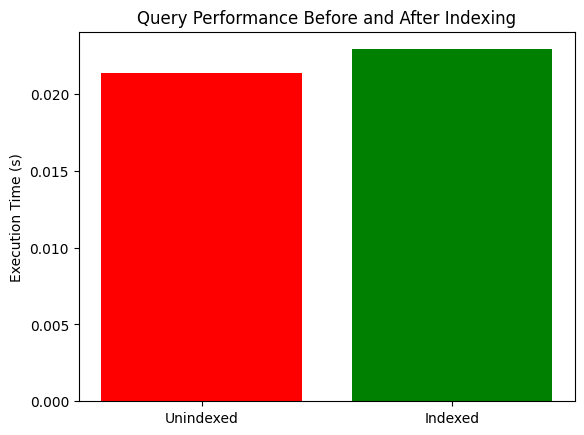

In [13]:
# Plot execution times
plt.bar(['Unindexed', 'Indexed'], [avg_time_unindexed, avg_time_indexed], color=['red', 'green'])
plt.ylabel("Execution Time (s)")
plt.title("Query Performance Before and After Indexing")
plt.show()

In [ ]:
# Close connection
con.close()